## Section F: Gaussian Process with BOTorch

### Gaussian Process Overview

A GP is a distribution over functions comprising of:
- **mean function** `m(x)`
- **kernel / covariance function** `k(x, x')`

The kernel controls:
- smoothness (how wiggly the function can be)
- lengthscale (how quickly it changes)
- amplitude / outputscale (vertical scale)

In practice, kernel hyperparameters are obtained or 'learned' by maximizing the **marginal log likelihood**.


### BOTorch

BoTorch is a library for Bayesian Optimization research built on top of PyTorch, and is part of the PyTorch ecosystem. https://arxiv.org/abs/1910.06403 

BoTorch builds on **GPyTorch**:
- **BoTorch** gives you: modeling conventions for BO, transformations, utilities, acquisition functions, optimization helpers.
- **GPyTorch** gives you: GP model classes, kernels, likelihoods, marginal log likelihoods, inference machinery.

### Importing relevant packages
(Feel free to import any packages you feel like needing to fully explore the content!)

In [ ]:
# if using google collab, run the following pip installs!
!pip install sobol_seq
!pip install plotly
!pip install gpytorch
!pip install rdkit
!pip install botorch

In [1]:
import os, math, time, warnings
from typing import Callable, Optional, Tuple, Dict, List

import torch
import matplotlib.pyplot as plt
import numpy as np

import botorch
import gpytorch


print("torch:", torch.__version__)
print("botorch:", botorch.__version__)
print("gpytorch:", gpytorch.__version__)


from botorch.models import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood


c:\Users\leeyo\anaconda3\envs\test_botorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch: 2.10.0+cpu
botorch: 0.16.1
gpytorch: 1.15.1


### Set device / dtype and a reproducible random seed

BOTorch uses PyTorch for tensor creation and manipulation. `torch.double` (float64) used for numerical stability. Default of Pytorch is float32. Allows numerical values to have 16 decimal digits rather than 7. Instability could manifest as the following errors: 

- RuntimeError: cholesky_cpu: ... not positive definite
- NaNs in the marginal log likelihood during fitting
- wildly oscillating hyperparameters
- acquisition values becoming NaN or inf


However, float64 makes code execution slower. For scaling up/big projects, try float32, but be weary of instaibility/adding some error handling. 

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

tkwargs = {"device": device, "dtype": dtype}

def set_seed(seed: int = 0):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)
print("device:", device, "| dtype:", dtype)


device: cpu | dtype: torch.float64


### 0. Data Shapes and BOTorch Conventions

BoTorch expects `tensors` as inputs, typically:

- train_X: (n, d)
- train_Y: (n, m) where m outputs (usually m=1 for single objective)

Optionally:
- train_Yvar: (n, m) for known noise variances

Common error:
- train_Y is shape (n) instead of (n,1)

### 0.1 Tensor Creation Basics

We can create tensors using the `torch` package. **tkwags for tensor creation:
- tkwargs defined previously 'tkwargs = {"device": device, "dtype": dtype}'; 
- ** expands the dictionary into keyword arguments 
- X_example = torch.rand(2, 2, **tkwargs) -> torch.rand(2, 2, device=device, dtype=dtype)
- Helps build tensors consistantly

**Examples** 

- From a list: 

```python 
A = torch.tensor([1, 2, 3], **tkwargs)                 # shape (3,)
B = torch.tensor([[1., 2.], [3., 4.]], **tkwargs)      # shape (2,2)
```

- Random tensors: A size (2,2) tensor filled with random numbers drawn uniformly from [0, 1]: 

```python
A = torch.rand(2, 2, **tkwargs)     # Uniform in [0, 1]:
B = torch.randn(2, 2, **tkwargs)    # Normal (Gaussian) mean=0, std=1:
C = torch.randint(low=0, high=10, size=(2, 3), **tkwargs) # Random intergers
```

- Constants: 
```python 
Z = torch.zeros(4, 2, **tkwargs)
O = torch.ones(4, 2, **tkwargs)
C = torch.full((4, 2), 7.5, **tkwargs)   # all 7.5
```

- Evenly spaced: 
```python 
A = torch.linspace(0, 1, 11, **tkwargs)   # 11 points from 0 to 1
B = torch.arange(0, 10, **tkwargs)        # 0,1,2,...,9
```

- From from an existing tensor (smae tkwargs): 
```python 
base = torch.rand(2, 3, **tkwargs)
Z = torch.zeros_like(base)
R = torch.rand_like(base)
N = torch.randn_like(base)
```

- Convert from Numpy: 
```python
arr = np.array([[1, 2], [3, 4]], dtype=np.float64)
T = torch.from_numpy(arr)           # shares memory with NumPy array
T = T.to(**tkwargs)                 # ensure dtype
```


### 0_2 Tensor Manipulation Basics

- Reshape: 

```python 
X = torch.rand(2, 3, 4) 
Y = X.reshape(6, 4)  
```

- Stack/concatenate tensors: 
```python
a = torch.rand(2, 3)
b = torch.rand(2, 3)

#concatenate
cat0 = torch.cat([a, b], dim=0)   # shape (4,3)  (rows)
cat1 = torch.cat([a, b], dim=1)   # shape (2,6)  (cols)

#stack
stk = torch.stack([a, b], dim=0)  # shape (2,2,3) (new dim)
```

- Flatten: 
```python
x = torch.rand(2, 3, 4)
flat = x.flatten() 
```

- Add or Remove dimensions: 
```python 
a = torch.rand(5)             # (5,)
b = a.unsqueeze(-1)           # (5,1)
c = b.squeeze(-1)             # back to (5,)
```

- Permute/Transpose dimensions 
```python 
x = torch.rand(2, 3, 4)
y = x.permute(1, 0, 2)        # reorder dims -> (3,2,4)

m = torch.rand(2, 3)
mt = m.transpose(0, 1)        # (3,2)
```

- Broadcasting (Allows for mathematical manipulation)
```python 
X = torch.rand(5, 3)         # (n,d)
m = X.mean(dim=0)            # (d,) - obtains mean of dim = 0
X_centered = X - m           # (5,3)  m broadcasts across rows
```

- Elementwise Math:
```python 
x = torch.rand(4, 3)
y = torch.sin(x) + 2*x          # performs transformation to each element
z = torch.clamp(x, 0.2, 0.8)    # places limits on mix or max - replaces element with specified min and max
```

- Elementwise Reductions: 
```python 
x = torch.rand(4, 3)
x_sum = x.sum()                  # scalar
col_mean = x.mean(dim=0)         # (3,)
row_max = x.max(dim=1).values    # (4,)
```

- Linear Algebra Basics: 
```python 
A = torch.rand(3, 4)
B = torch.rand(4, 2)
C = A @ B                    # matrix multiply -> (3,2)

v = torch.rand(4)
out = A @ v                  # (3,)
```

- Useful Linear Algebra for BO: 
```python
torch.matmul(A, B)          # computes matrix product (able to handel matrix x matrix; matrix x vector; vector x vector)
torch.linalg.solve(M, b)    # Solves a linear system without inverting
torch.linalg.cholesky(K)    # Cholesky factorization - add jitter if encounter numerical issues
```

### Exercise 0_1:

What are the sizes for the following tensors? Are the following inputs following convention for BOTorch inputs? 

```python
Train_X example: 
tensor([[0.0207, 0.4976],
        [0.0830, 0.2842],
        [0.5929, 0.9326],
        [0.4929, 0.5978],
        [0.2802, 0.7105],
        [0.6407, 0.2061],
        [0.2936, 0.7878],
        [0.1641, 0.2045]], dtype=torch.float64)
```
```python
Train_Y example: 
tensor([0.2703, 0.4023, 0.9760, 0.1356, 0.2899, 0.8634, 0.5567, 0.7600],
       dtype=torch.float64)
```



### 1. Example of 1D Gausian Process regression

We define the follwing objective function: 
- `f_true(x) = sin(2πx) + 0.25 x`

We will evaluate the objective function as:
- `y = f_true(x) + ε`
- with `ε` as added noise/error

### Exercise 1_1:

Create a function for the objective function: 
```python 
def f_objective_1d(x: torch.Tensor) -> torch.Tensor:
    return ...
```

Then execute the code below to observe the model function.

```python
# setting ε
NOISE_STD = 0.15 

# Evaluating objective function
n_init = 10
train_X = torch.rand(n_init, 1, **tkwargs)
train_Y_true = f_objective_1d(train_X)
train_Y = train_Y_true + NOISE_STD * torch.randn_like(train_Y_true)

# Creating objective function dataset for visualisation
test_X = torch.linspace(0, 1, 400, **tkwargs).unsqueeze(-1)
test_Y_true = f_objective_1d(test_X)

# Visualisation 
plt.figure(figsize=(9, 3))
plt.plot(test_X.cpu(), test_Y_true.cpu(), label="true f(x)")
plt.scatter(train_X.cpu(), train_Y.cpu(), label="noisy observations")
plt.xlabel("x"); plt.ylabel("y"); plt.title("Toy 1D function")
plt.legend()
plt.show()
```

### 1.1 GP Regression with `SingleTaskGP`

A GP model contains:
- mean module (often constant)
- covariance module (kernel + outputscale)
- likelihood (Gaussian noise)
- learned hyperparameters (lengthscale, outputscale, noise)

BoTorch’s `SingleTaskGP` is a wrapper around GPyTorch. We can perform GP regression simply by using `SingleTaskGP` without having to do any mathematical operations. 

#### 1. Initialising the GP model

```python 
model = SingleTaskGP(
    train_X,
    train_Y,
    input_transform=Normalize(d=1),
    outcome_transform=Standardize(m=1),
).to(**tkwargs)

print(model)
print("Likelihood:", model.likelihood)
print("Covar module:", model.covar_module)
print("Mean module:", model.mean_module)
```

Comments: 
- `SingleTaskGP` - For objective/output -> train_Y is typically sized (n,1)
- `input_transform=Normalize(d=1)` - Normalise train_X before perfoming regression; `d=1` describes input has 1 dimension, if there is 5, use 'd=5'
- `outcome_transform=Standardize(m=1)` - Standarises train_Y before performing regression (outputs have mean ≈ 0; sd ≈ 1); `m=1` refer to 1 output dimention, if there is 2 (multi-objective), use 'd=2'
- Here, we have not specified a covariance module (kernel), the kernel defaults to RBF Kernel. 
- We can print each module to obtain information about the model. 


#### 2. Hyperparameter learning

```python 
mll = ExactMarginalLogLikelihood(model.likelihood, model)fit_gpytorch_mll(mll)
```

Comments: 
- `ExactMarginalLogLikelihood(model.likelihood, model)` - creates the training objective used to fit GP hyperparameters (marginal log likelyhood); `model.likelihood` handels observation noise - here, the model learns the noise unless `train_Yvar` (known noise) is passed; `model` the model created from `SingleTaskGP`.
- `fit_gpytorch_mll(mll)`- optimises GP hyperparameters by maximizing mll. 
- After fitting, `model` object will have additional attributes related to the fitted  

#### 3. Extracting posterior, mean and std

```python
with torch.no_grad():
    posterior = model.posterior(test_X)
    mean = posterior.mean.squeeze(-1)
    std = posterior.variance.sqrt().squeeze(-1)
```

Comments: 
- PyTorch uses `autograd` by default which records every operation that is done on tensors which require gradients then builds a computation graph such that it can compute derivatives if nessary. 
- `torch.no_grad()` - here, we are merely obtaining the mean and std for plots, we do not need a computation graph stored (uses less memory and is usually faster)
- when copying tensors, we can also use the method `.detach()` to copy to a new variable without the computation graph - useful if we are converting tensors to numpy arrays (otherwise we could obtain a 'grad-tracked' warning/error)
- `model.posterior(test_X)` - returns a distribution which we can obtain the mean, standard deviation and draw samples from the posterior from. 

#### 4. Visualisation 

```python 
# plotting with +- 2 std fill-in
plt.figure(figsize=(9, 4))
plt.scatter(train_X.cpu().squeeze(-1), train_Y.cpu().squeeze(-1), label="data")
plt.plot(test_X.cpu().squeeze(-1), mean.cpu(), label="posterior mean")
plt.fill_between(test_X.cpu().squeeze(-1), (mean-2*std).cpu(), (mean+2*std).cpu(), alpha=0.2, label="±2σ")
plt.plot(test_X.cpu().squeeze(-1), test_Y_true.cpu().squeeze(-1), linestyle="--", label="true f(x)")
plt.title("BoTorch SingleTaskGP posterior")
plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.show()

# learned hyperparameters
print("Learned noise variance:", model.likelihood.noise.item())
print("Lengthscale:", model.covar_module.lengthscale.item())
```

### Exercise 1_2: 

Perform a simple 1D GP regression for the previously observed values in `train_X` and `train_Y`. 

Observe and compare the learned noise variance to the `NOISE_STD` value set, and the learned lengthscale to the periodicity of the objective function. 

Try changing the 1D function or increasing the number of observations - how does this influence the GP regression?  

### 1.2 Sampling from the Posterior

We can also sample form the posterior as well. A reason for doing this is that it might be useful in multi-batch BO ex. for Thompson Sampling. Example: 

```python
# 10 samples are drawn from the posterior

with torch.no_grad():
    posterior = model.posterior(test_X)
    samples = posterior.rsample(sample_shape=torch.Size([10]))  # (10, n_test, 1)

x_plot = test_X.squeeze(-1).detach().cpu()
mu_plot = posterior.mean.squeeze(-1).detach().cpu()

plt.figure(figsize=(9, 4))
plt.scatter(train_X.squeeze(-1).detach().cpu(), train_Y.squeeze(-1).detach().cpu(), label="data")
plt.plot(x_plot, mu_plot, label="mean")

for i in range(samples.shape[0]):
    plt.plot(x_plot, samples[i].squeeze(-1).detach().cpu(), alpha=0.5)

plt.title("Posterior samples (10 draws)")
plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.show()
```

#### 2. Effect of Kernels

We can change kernels by specifying the covariance module. 

Here, we use `ScaleKernel()` object for the covariance module. `ScaleKernel()` wraps a kernel and introduces an additional hyperparameter called the **outputscale**.  The resulting kernel is: 

$$
k(x, x') = \text{outputscale} \cdot k_{\text{base}}(x, x')
$$

The outputscale determines the verticle amplitude. We already perform standaridation on `train_Y` and therefore this is largely unessasry. However, ScaleKernel can be helpful in senarios where standarisation is not performed or the scales changes over time or there are multiple objectives with different magnitudes etc.
 
We can define a helper function for GP regression which allow for a kernel to be used. For example:

```python
def fit_with_kernel(kernel, X, Y):
    covar = ScaleKernel(kernel)
    m = SingleTaskGP(
        X, Y,
        covar_module=covar,
        input_transform=Normalize(d=X.shape[-1]),
        outcome_transform=Standardize(m=1),
    ).to(**tkwargs)
    mll = ExactMarginalLogLikelihood(m.likelihood, m)
    fit_gpytorch_mll(mll)
    return m, covar
```

Once GP regression is performed. The learned hyperparameters (lengthscale and outputscale) can be obtained as attributes of the `ScaleKernel()` object. 

```python
print(covar.base_kernel.lengthscale)
print(covar.outputscale)
```

We do not need to define ourselves common kernels such as the RBF or Matern family of kernels. These can be found int he `gpytorch` package. See here for a list of available kernels: https://docs.gpytorch.ai/en/stable/kernels.html#standard-kernels 

```python 
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel

model_rbf = fit_with_kernel(RBFKernel(), train_X, train_Y)
model_mat = fit_with_kernel(MaternKernel(nu=2.5), train_X, train_Y)
```


### Exercise 2_1 

Perform GP regression on `train_X` and `train_Y` with both RBF and Matern2.5 kernel. 

Obtain and compare the learned hyperparameters (noise, lengthscale and outputscale).

### Exercise 2_2

Sample 5 functions from the posterior of the matern2.5 kernel. How does the function differ from those of the RBF kernel? 

### 3. Known Noise

We have previously modeled noise as a learned value. However, if we know the noise/error for our system, for example from replication, we can explicitly model this by passing `train_Yvar` into `SingleTaskGP()`

```python
sigma_known = 0.15
train_Yvar = torch.full_like(train_Y, sigma_known**2)

model_fixed_noise = SingleTaskGP(
    train_X, train_Y,
    train_Yvar=train_Yvar, # <---------
    input_transform=Normalize(d=1),
    outcome_transform=Standardize(m=1),
).to(**tkwargs)
mll_fn = ExactMarginalLogLikelihood(model_fixed_noise.likelihood, model_fixed_noise)
fit_gpytorch_mll(mll_fn)
print("Fixed-noise model fit complete.")
```

### 4. Multi-dimensional inputs 

We can now extend our 1D example into multiple dimensions. We use the Branin function (https://www.sfu.ca/~ssurjano/branin.html) as a complex example of a function with 2 input dimensions. 

3D plot of the objective function:
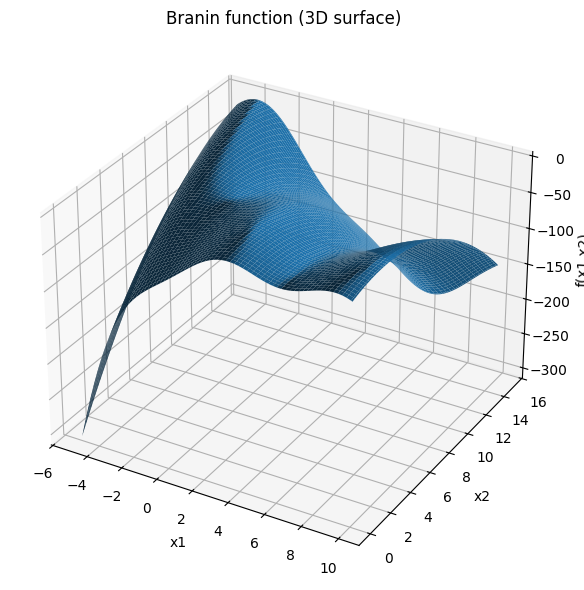

We can draw samples from the Branin functions using the example below.

```python
branin = Branin(negate=True).to(**tkwargs)
bounds2 = branin.bounds.to(**tkwargs)

def branin_obj(X):
    return branin(X).unsqueeze(-1)

n_init2 = 25
X2 = draw_sobol_samples(bounds=bounds2, n=n_init2, q=1).squeeze(1).to(**tkwargs)
Y2 = branin_obj(X2).to(**tkwargs)
```

Comments: 
- `Branin(negate=True)` - creates a test function object but returns -Branin(x) instead, this is done as it will be relevant to other parts of the notebooks later - BOTorch assumes we are maximizing, Branin test function is usually used for testing minimisation functions
- `.to(**tkwargs)` - moves the function object to the device and dtype we previously specified
- `branin.bounds` - pre-set bounds for the branin functions, here this is a tensor with shape (2,2)
- `branin(X).unsqueeze(-1)` - evaluates the function at input points X (of shape (n,2)), then outputs tensor of shape (n,1) - .`unsqueeze()` performed so that it is compatible with GP regression
- `draw_sobol_samples(bounds=bounds2, n=n_init2, q=1)` - draws `n_init2` sets of random sample of `q=1` point per set within the size and bounds specified by `bounds2`. The returned shape is `(n, q, d)` for branin function. `squeeze(1)` removes the `q` dimension (as it is size 1) to obtain tensor of size (n,d). 
- `Y2 = branin_obj(X2)` - evaluates function at all `n_init2` number of points. 



Kernels often learn a separate lengthscale per dimension. This is commonly refered to as automatic relevance determination (ARD), as smaller lengthscales correlate to higher degree of dependancy of the input (more relavant). We can provide the input dimension information to the `ScaleKernel()` via the `ard_num_dims=` keyword. 

```python
d = train_X.shape[-1]
covar = ScaleKernel(RBFKernel(ard_num_dims=d))
```

We can use the same `SingleTaskGP()` object to perform the multi-dimensional GP refression. Errors usually arise when the inputs and output tensors are not correctly sized. Here is an example of a multidimensional GP regression.

```python 
X2n = normalize(X2, bounds2)
d = X2n.shape[-1]
covar = ScaleKernel(RBFKernel(ard_num_dims=d))
model2d = SingleTaskGP(X2n, Y2, 
                       covar_module = covar,
                       outcome_transform=Standardize(m=1)).to(**tkwargs)
mll2d = ExactMarginalLogLikelihood(model2d.likelihood, model2d)
fit_gpytorch_mll(mll2d)

ls = model2d.covar_module.base_kernel.lengthscale.detach().cpu().view(-1).numpy()
print("ARD lengthscales:", ls)
```

### Exercise 4_1

Perform GP regression on Branin function and determine which input dimension has a higher influence on the output. 

Play around with the number of points used for regression. How does this influence the lengthscales that are 'learned'? 

Additionally, you could also plot and visualise the posterior mean and compare it to the objective function. You could also plot the posterior std. 

Tip: the unnormalize() function could help to translate back into the input space (to plot the posterior mean/std) if you created a test grid that is in the normalized input space. 

```python
from botorch.utils.transforms import unnormalize
grid_orig = unnormalize(grid_n,  # grid in the normalised space
                        bounds2) # bounds of the branin function previously defined
```

**Well done** for completing the notebook! 

Segue into Bayesian Optimisation: By observing the posterior mean/std plots, if we would want to perform maximisation, where best in the input space should we evaluate next? Is there a best case for full exploitation or exploration? 

Posterior mean/std plots (n = 10):


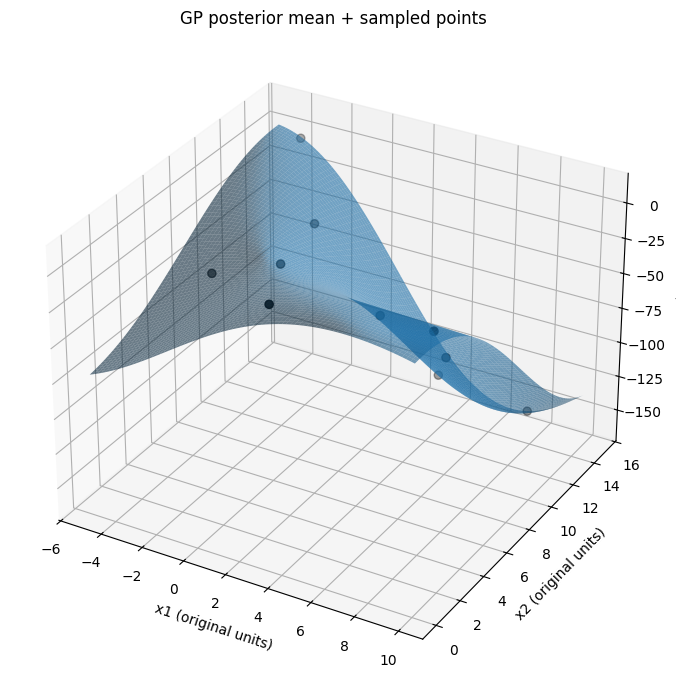
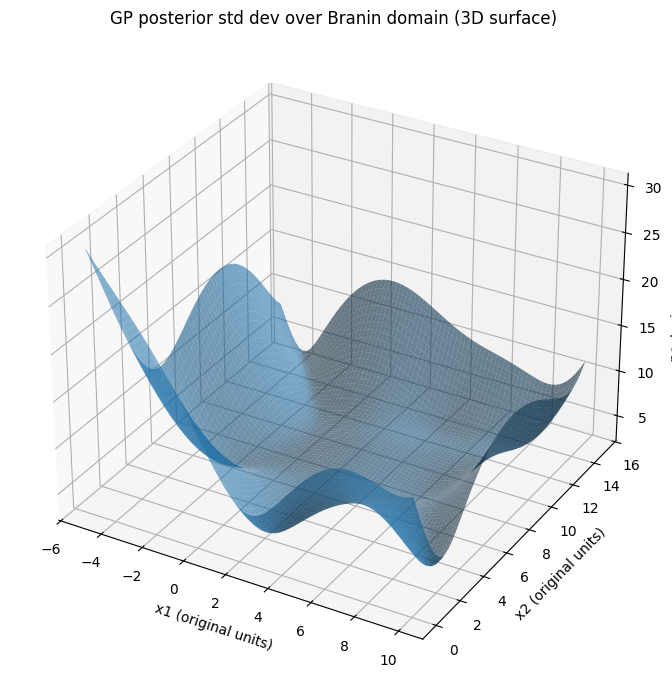